In [14]:
"""
Script to decode token IDs from example.txt using Qwen3 tokenizer.
Handles special memory tokens (IDs larger than vocab size) by replacing them with '<MT>'.
Handles label masking tokens (-100) by replacing them with '<-100>'.
"""

import ast
from transformers import AutoTokenizer
from typing import List

def safe_decode_with_mem_tokens(tokenizer, token_ids: List[int]) -> str:
    """
    Decodes token IDs, replacing tokens larger than vocab size with '<MT>' 
    for special 'MEM_TOKEN' tokens, and -100 with '<-100>' for label masking.
    
    Args:
        tokenizer: HuggingFace tokenizer
        token_ids: List of token IDs to decode
        
    Returns:
        Decoded string with memory tokens replaced by '<MT>' and -100 replaced by '<-100>'
    """
    vocab_size = tokenizer.vocab_size
    
    # Convert IDs to tokens, replacing out-of-vocab IDs with None
    tokens = []
    for token_id in token_ids:
        if token_id == -100:
            # Label masking token
            tokens.append("<-100>")
        elif token_id <= vocab_size + 50:
            token = tokenizer.convert_ids_to_tokens([token_id])[0]
            tokens.append(token)
        else:
            # Token ID is larger than vocab size - this is a memory token
            tokens.append("<MT>")
    
    # Convert tokens to string, replacing special placeholders as needed
    result = tokenizer.convert_tokens_to_string(tokens)
    return result


In [22]:
'''# Qwen3 tokenizer from HuggingFace
print("Loading Qwen3 tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B", trust_remote_code=True)

# Read the example.txt file
print("Reading example.txt...")
with open('example.txt', 'r') as f:
    content = f.read()

# Parse the content (assuming it's a dictionary-like string)
print("Parsing token IDs...")
try:
    # Try to evaluate as a Python literal
    data = ast.literal_eval("{" + content + "}")
except:
    # If that fails, try to parse manually
    import re
    data = {}
    
    # Extract input_ids
    input_ids_match = re.search(r"'input_ids':\s*\[([\d,\s]+)\]", content)
    if input_ids_match:
        data['input_ids'] = [int(x.strip()) for x in input_ids_match.group(1).split(',') if x.strip()]
    
    # Extract prompt_answer_ids
    prompt_answer_ids_match = re.search(r"'prompt_answer_ids':\s*\[([\d,\s]+)\]", content)
    if prompt_answer_ids_match:
        data['prompt_answer_ids'] = [int(x.strip()) for x in prompt_answer_ids_match.group(1).split(',') if x.strip()]
    
    # Extract labels
    labels_match = re.search(r"'labels':\s*\[([\d,\s-]+)\]", content)
    if labels_match:
        data['labels'] = [int(x.strip()) for x in labels_match.group(1).split(',') if x.strip()]

print(f"\nVocabulary size: {tokenizer.vocab_size}")
print("=" * 80)

# Decode each field
for key, token_ids in data.items():
    if isinstance(token_ids, list) and token_ids:
        print(f"\n{key}:")
        print(f"  Length: {len(token_ids)} tokens")
        
        # Count memory tokens
        mem_token_count = sum(1 for tid in token_ids if tid > tokenizer.vocab_size)
        if mem_token_count > 0:
            print(f"  Memory tokens: {mem_token_count}")
        
        # Decode
        decoded = safe_decode_with_mem_tokens(tokenizer, token_ids)
        print(f"  Decoded text:")
        print(decoded)
        print()
'''

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1318298/3468744742.py:1: SyntaxWarning: invalid escape sequence '\s'
  '''# Qwen3 tokenizer from HuggingFace


'# Qwen3 tokenizer from HuggingFace\nprint("Loading Qwen3 tokenizer...")\ntokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B", trust_remote_code=True)\n\n# Read the example.txt file\nprint("Reading example.txt...")\nwith open(\'example.txt\', \'r\') as f:\n    content = f.read()\n\n# Parse the content (assuming it\'s a dictionary-like string)\nprint("Parsing token IDs...")\ntry:\n    # Try to evaluate as a Python literal\n    data = ast.literal_eval("{" + content + "}")\nexcept:\n    # If that fails, try to parse manually\n    import re\n    data = {}\n\n    # Extract input_ids\n    input_ids_match = re.search(r"\'input_ids\':\\s*\\[([\\d,\\s]+)\\]", content)\n    if input_ids_match:\n        data[\'input_ids\'] = [int(x.strip()) for x in input_ids_match.group(1).split(\',\') if x.strip()]\n\n    # Extract prompt_answer_ids\n    prompt_answer_ids_match = re.search(r"\'prompt_answer_ids\':\\s*\\[([\\d,\\s]+)\\]", content)\n    if prompt_answer_ids_match:\n        data[\'prompt_ans

Qwen3-8B (baseline):
  checkpoint: base weights
  mean_bleu: 0.8090
  mean_similarity: 0.7630
  pass_at_threshold_0.8: 0.65

Qwen3-8B ICAE-PT:
  checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_2607_1024_4_1B/checkpoint-12000/model.safetensors
  mean_bleu: 0.1272
  mean_similarity: 0.0267
  pass_at_threshold_0.8: 0.01

Qwen3-8B ICAE-PT+FT:
  checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/finetune/repoqa-icae-0411-lr1e-4/checkpoint-4000/model.safetensors
  mean_bleu: 0.8680
  mean_similarity: 0.8010
  pass_at_threshold_0.8: 0.69

Qwen3-8B LoRA:
  checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/finetune/repoqa-simplellm-0411-lr4/checkpoint-1000/model.safetensors
  mean_bleu: 0.9037
  mean_similarity: 0.8977
  pass_at_threshold_0.8: 0.85



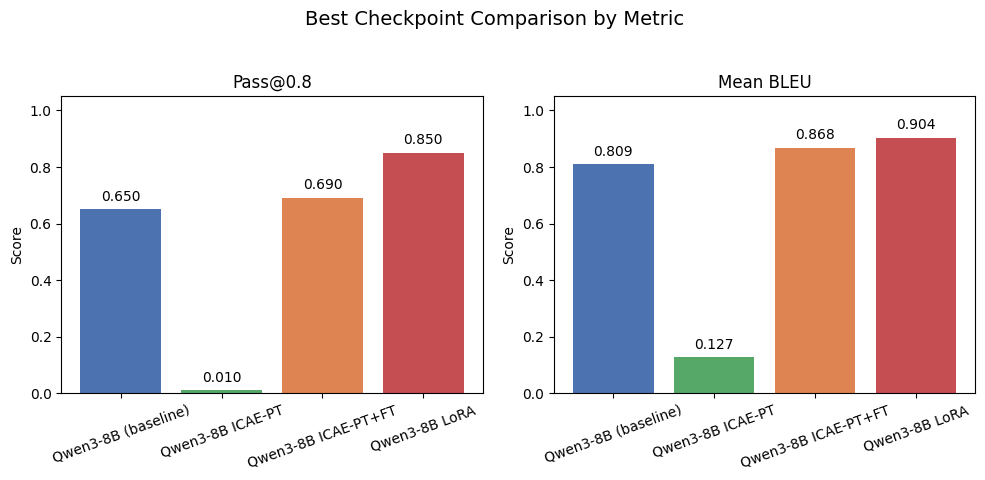

In [ ]:
import json
from pathlib import Path
import matplotlib.pyplot as plt


def load_metrics(file_path: str):
    raw = Path(file_path).read_text().strip()
    if not raw:
        return []
    # Split at first comment (line starting with //) and only process content before it
    lines = raw.split('\n')
    content_lines = []
    for line in lines:
        stripped = line.strip()
        if stripped.startswith('//'):
            break
        content_lines.append(line)
    raw = '\n'.join(content_lines)
    json_ready = "[" + raw.replace("}{", "},{") + "]"
    return json.loads(json_ready)


def pick_best(entries, label):
    if not entries:
        raise ValueError(f"No metrics entries found for {label}.")
    return max(
        entries,
        key=lambda m: (
            m["pass_at_threshold_0.8"],
            m["mean_bleu"],
            m["mean_similarity"],
        ),
    )


llm_metrics = load_metrics("data/metrics/metrics_repoqa_llm.json")
icae_metrics = load_metrics("data/metrics/metrics_repoqa_icae.json")

baseline_best = pick_best(
    [m for m in llm_metrics if m.get("restore_from", "") == ""],
    "baseline Qwen3-8B",
)
simplellm_best = pick_best(
    [m for m in llm_metrics if "simplellm" in m.get("restore_from", "")],
    "LoRA-finetuned Qwen3-8B",
)
icae_pt_best = pick_best(
    [m for m in icae_metrics if m.get("restore_from", "") == "/mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_2607_1024_4_1B/checkpoint-12000/model.safetensors"],
    "ICAE-PT",
)
icae_pt_ft_best = pick_best(
    [m for m in icae_metrics if "icae" in m.get("restore_from", "") and "finetune" in m.get("restore_from", "")],
    "ICAE-PT+FT",
)

best_models = {
    "Qwen3-8B (baseline)": baseline_best,
    "Qwen3-8B ICAE-PT": icae_pt_best,
    "Qwen3-8B ICAE-PT+FT": icae_pt_ft_best,
    "Qwen3-8B LoRA": simplellm_best,
}

for name, stats in best_models.items():
    checkpoint = stats["restore_from"] or "base weights"
    print(f"{name}:")
    print(f"  checkpoint: {checkpoint}")
    print(f"  mean_bleu: {stats['mean_bleu']:.4f}")
    print(f"  mean_similarity: {stats['mean_similarity']:.4f}")
    print(f"  pass_at_threshold_0.8: {stats['pass_at_threshold_0.8']:.2f}")
    print()

metrics_to_plot = {
    "pass_at_threshold_0.8": "Pass@0.8",
    "mean_bleu": "Mean BLEU",
}

model_labels = list(best_models.keys())
colors = ["#4C72B0", "#55A868", "#DD8452", "#C44E52"]

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(10, 5))

if len(metrics_to_plot) == 1:
    axes = [axes]

for ax, (metric_key, title) in zip(axes, metrics_to_plot.items()):
    values = [best_models[label][metric_key] for label in model_labels]
    bars = ax.bar(model_labels, values, color=colors)
    ax.set_title(title)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    for bar, value in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + 0.02,
            f"{value:.3f}",
            ha="center",
            va="bottom",
        )
    ax.tick_params(axis="x", rotation=20)

fig.suptitle("Best Checkpoint Comparison by Metric", fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Qwen3-8B (baseline):
  checkpoint: base weights
  mean_em: 0.5400
  mean_f1: 0.7559

Qwen3-8B ICAE-PT:
  checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_2607_1024_4_1B/checkpoint-12000/model.safetensors
  mean_em: 0.5100
  mean_f1: 0.7254

Qwen3-8B ICAE-PT+FT:
  checkpoint: icae/data/checkpoints/qwen_finetune_1207-icae-75k/checkpoint-15000/model.safetensors
  mean_em: 0.6680
  mean_f1: 0.8231

Qwen3-8B LoRA:
  checkpoint: icae/data/checkpoints/qwen_finetune_1207-llm-shuffled/checkpoint-10000/model.safetensors
  mean_em: 0.7040
  mean_f1: 0.8552



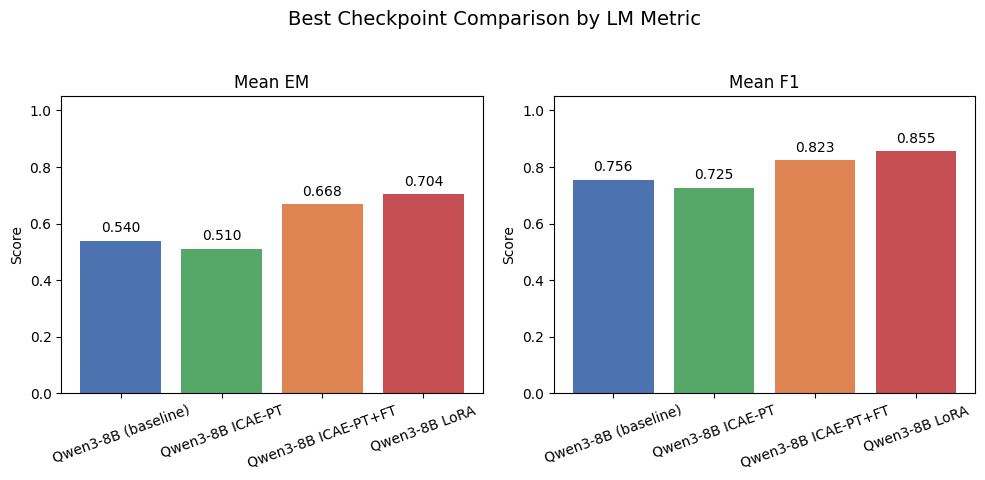

In [25]:
# Load LM metrics
llm_lm_metrics = load_metrics("data/metrics/metrics_lm_llm.json")
icae_lm_metrics = load_metrics("data/metrics/metrics_lm_icae.json")

# Helper function to pick best by EM and F1
def pick_best_lm(entries, label):
    if not entries:
        raise ValueError(f"No metrics entries found for {label}.")
    return max(
        entries,
        key=lambda m: (m["mean_em"], m["mean_f1"]),
    )

lm_baseline_best = pick_best_lm(
    [m for m in llm_lm_metrics if m.get("restore_from", "") == ""],
    "baseline Qwen3-8B LM",
)
lm_lora_best = pick_best_lm(
    [m for m in llm_lm_metrics if m.get("restore_from", "") != ""],
    "LoRA-finetuned Qwen3-8B LM",
)
lm_icae_pt_best = pick_best_lm(
    [m for m in icae_lm_metrics if m.get("restore_from", "") == "/mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_2607_1024_4_1B/checkpoint-12000/model.safetensors"],
    "ICAE-PT LM",
)
lm_icae_pt_ft_best = pick_best_lm(
    [m for m in icae_lm_metrics if "finetune" in m.get("restore_from", "")],
    "ICAE-PT+FT LM",
)

best_lm_models = {
    "Qwen3-8B (baseline)": lm_baseline_best,
    "Qwen3-8B ICAE-PT": lm_icae_pt_best,
    "Qwen3-8B ICAE-PT+FT": lm_icae_pt_ft_best,
    "Qwen3-8B LoRA": lm_lora_best,
}

for name, stats in best_lm_models.items():
    checkpoint = stats["restore_from"] or "base weights"
    print(f"{name}:")
    print(f"  checkpoint: {checkpoint}")
    print(f"  mean_em: {stats['mean_em']:.4f}")
    print(f"  mean_f1: {stats['mean_f1']:.4f}")
    print()

lm_metrics_to_plot = {
    "mean_em": "Mean EM",
    "mean_f1": "Mean F1",
}

lm_model_labels = list(best_lm_models.keys())
lm_colors = ["#4C72B0", "#55A868", "#DD8452", "#C44E52"]

fig, axes = plt.subplots(1, len(lm_metrics_to_plot), figsize=(10, 5))

if len(lm_metrics_to_plot) == 1:
    axes = [axes]

for ax, (metric_key, title) in zip(axes, lm_metrics_to_plot.items()):
    values = [best_lm_models[label][metric_key] for label in lm_model_labels]
    bars = ax.bar(lm_model_labels, values, color=lm_colors)
    ax.set_title(title)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    for bar, value in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + 0.02,
            f"{value:.3f}",
            ha="center",
            va="bottom",
        )
    ax.tick_params(axis="x", rotation=20)

fig.suptitle("Best Checkpoint Comparison by LM Metric", fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Qwen3-8B (baseline):
  accuracy: 0.8967
  resolved: 26/500

Qwen3-8B ICAE-PT:
  accuracy: 0.8808
  resolved: 0/500

Qwen3-8B ICAE-PT+FT:
  accuracy: 0.9020
  resolved: 11/500

Qwen3-8B LoRA:
  accuracy: 0.9118
  resolved: 10/500



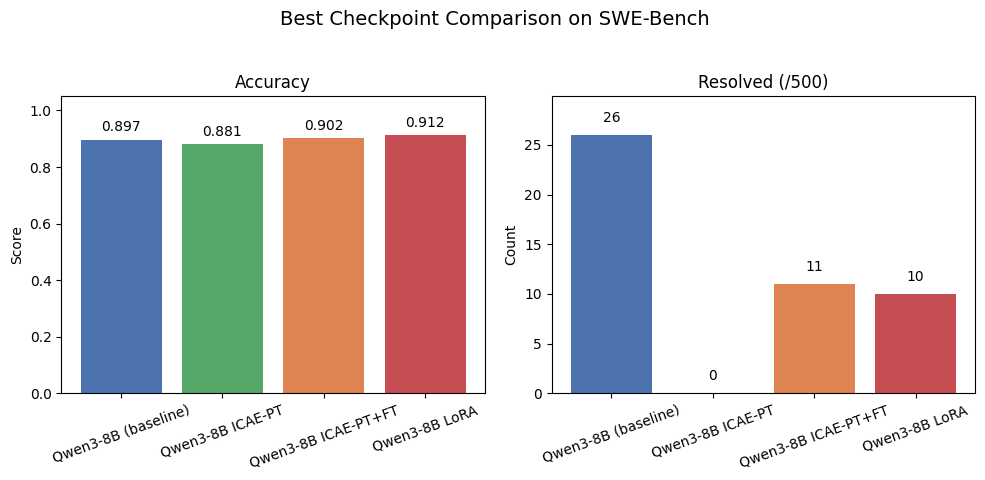

In [26]:
# Load SWE-Bench metrics (hardcoded for now)
swe_bench_metrics = {
    "Qwen3-8B (baseline)": {
        "accuracy": 0.8967,
        "resolved": 26,
    },
    "Qwen3-8B ICAE-PT": {
        "accuracy": 0.8808,
        "resolved": 0,
    },
    "Qwen3-8B ICAE-PT+FT": {
        "accuracy": 0.9020,
        "resolved": 11,
    },
    "Qwen3-8B LoRA": {
        "accuracy": 0.9118,
        "resolved": 10,
    },
}

for name, stats in swe_bench_metrics.items():
    print(f"{name}:")
    print(f"  accuracy: {stats['accuracy']:.4f}")
    print(f"  resolved: {stats['resolved']}/500")
    print()

swe_bench_metrics_to_plot = {
    "accuracy": "Accuracy",
    "resolved": "Resolved (/500)",
}

swe_bench_model_labels = list(swe_bench_metrics.keys())
swe_bench_colors = ["#4C72B0", "#55A868", "#DD8452", "#C44E52"]

fig, axes = plt.subplots(1, len(swe_bench_metrics_to_plot), figsize=(10, 5))

if len(swe_bench_metrics_to_plot) == 1:
    axes = [axes]

for ax, (metric_key, title) in zip(axes, swe_bench_metrics_to_plot.items()):
    values = [swe_bench_metrics[label][metric_key] for label in swe_bench_model_labels]
    bars = ax.bar(swe_bench_model_labels, values, color=swe_bench_colors)
    ax.set_title(title)
    if metric_key == "accuracy":
        ax.set_ylim(0, 1.05)
        ax.set_ylabel("Score")
        for bar, value in zip(bars, values):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                value + 0.02,
                f"{value:.3f}",
                ha="center",
                va="bottom",
            )
    else:  # resolved
        ax.set_ylim(0, max(values) * 1.15)
        ax.set_ylabel("Count")
        for bar, value in zip(bars, values):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                value + 1,
                f"{int(value)}",
                ha="center",
                va="bottom",
            )
    ax.tick_params(axis="x", rotation=20)

fig.suptitle("Best Checkpoint Comparison on SWE-Bench", fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


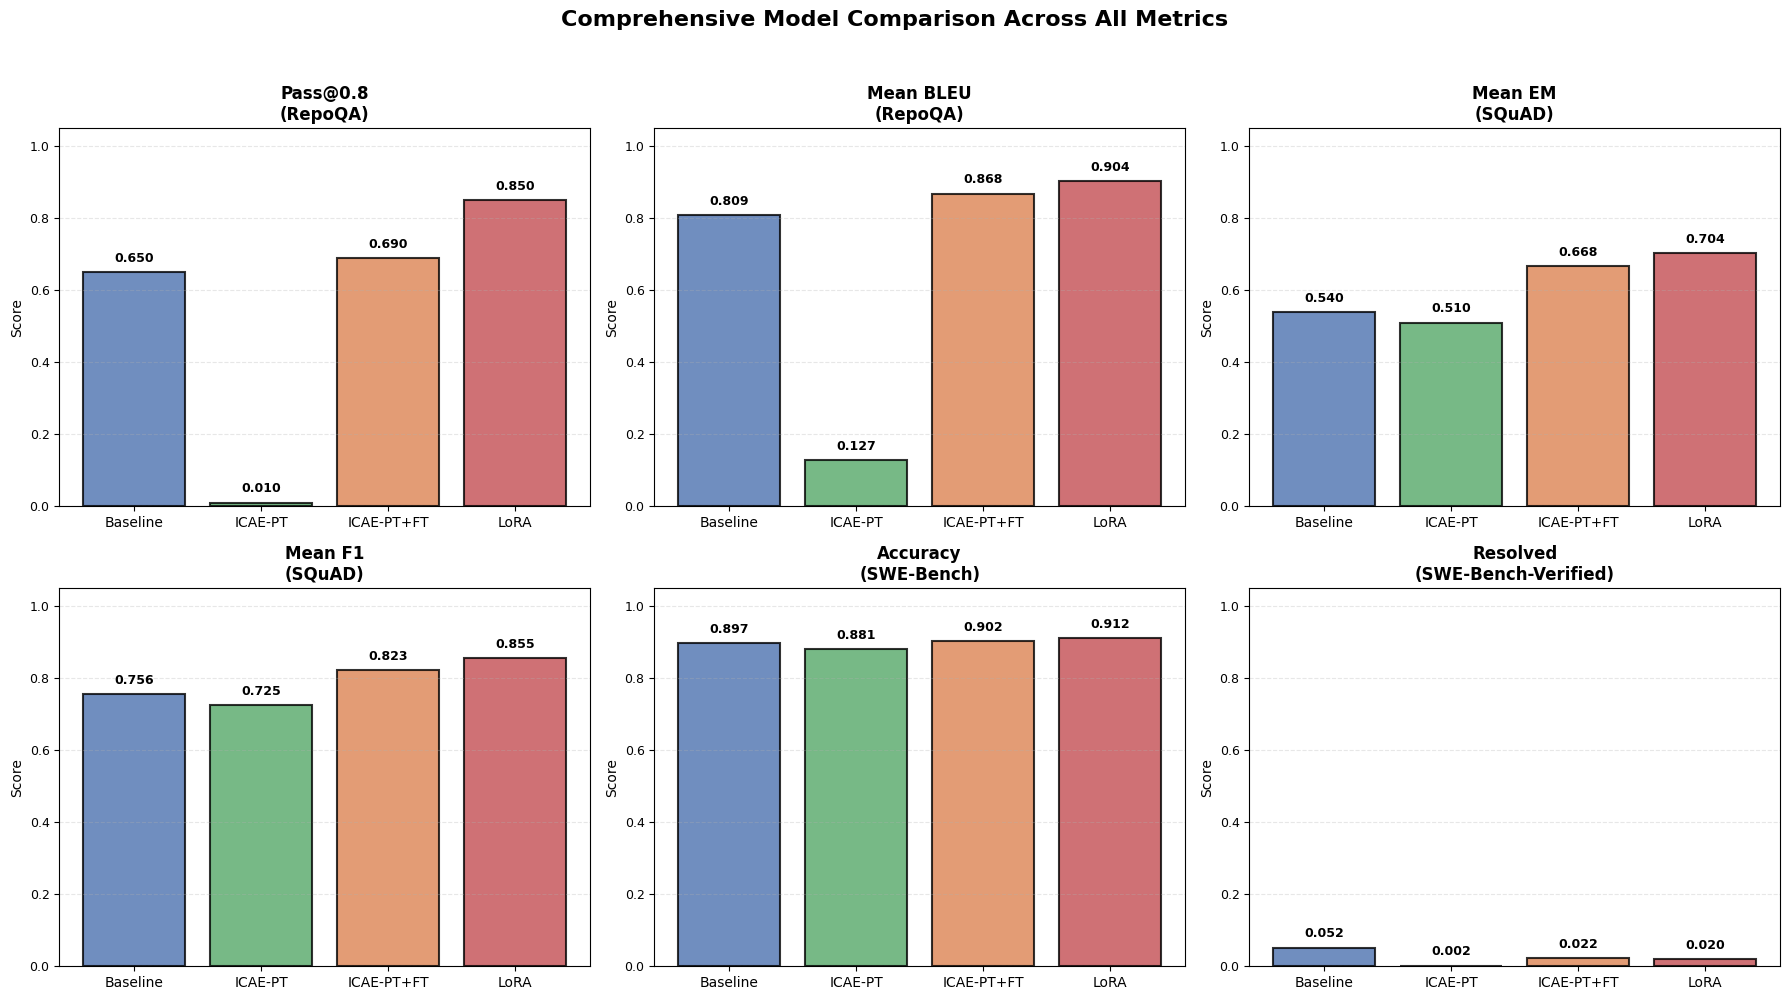


SUMMARY: All Metrics Comparison
Model        Pass@0.8   BLEU     EM       F1       Accuracy   Resolved  
------------------------------------------------------------------------------------------
Baseline     0.650      0.809    0.540    0.756    0.897      0.052     
ICAE-PT      0.010      0.127    0.510    0.725    0.881      0.002     
ICAE-PT+FT   0.690      0.868    0.668    0.823    0.902      0.022     
LoRA         0.850      0.904    0.704    0.855    0.912      0.020     


In [27]:
import numpy as np

# Collect all metrics data
all_metrics_data = {
    "Baseline": {
        "pass_at_threshold_0.8": baseline_best["pass_at_threshold_0.8"],
        "mean_bleu": baseline_best["mean_bleu"],
        "mean_em": lm_baseline_best["mean_em"],
        "mean_f1": lm_baseline_best["mean_f1"],
        "accuracy": swe_bench_metrics["Qwen3-8B (baseline)"]["accuracy"],
        "resolved": 26.0 / 500.0,
    },
    "ICAE-PT": {
        "pass_at_threshold_0.8": icae_pt_best["pass_at_threshold_0.8"],
        "mean_bleu": icae_pt_best["mean_bleu"],
        "mean_em": lm_icae_pt_best["mean_em"],
        "mean_f1": lm_icae_pt_best["mean_f1"],
        "accuracy": swe_bench_metrics["Qwen3-8B ICAE-PT"]["accuracy"],
        "resolved": 1.0 / 500.0,
    },
    "ICAE-PT+FT": {
        "pass_at_threshold_0.8": icae_pt_ft_best["pass_at_threshold_0.8"],
        "mean_bleu": icae_pt_ft_best["mean_bleu"],
        "mean_em": lm_icae_pt_ft_best["mean_em"],
        "mean_f1": lm_icae_pt_ft_best["mean_f1"],
        "accuracy": swe_bench_metrics["Qwen3-8B ICAE-PT+FT"]["accuracy"],
        "resolved": 11.0 / 500.0,
    },
    "LoRA": {
        "pass_at_threshold_0.8": simplellm_best["pass_at_threshold_0.8"],
        "mean_bleu": simplellm_best["mean_bleu"],
        "mean_em": lm_lora_best["mean_em"],
        "mean_f1": lm_lora_best["mean_f1"],
        "accuracy": swe_bench_metrics["Qwen3-8B LoRA"]["accuracy"],
        "resolved": 10.0 / 500.0,
    },
}

# Define metric labels and colors
metric_labels = [
    "Pass@0.8\n(RepoQA)",
    "Mean BLEU\n(RepoQA)",
    "Mean EM\n(SQuAD)",
    "Mean F1\n(SQuAD)",
    "Accuracy\n(SWE-Bench)",
    "Resolved\n(SWE-Bench-Verified)",
]

model_order = ["Baseline", "ICAE-PT", "ICAE-PT+FT", "LoRA"]
model_colors = ["#4C72B0", "#55A868", "#DD8452", "#C44E52"]  # Blue, Green, Orange, Red

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot each metric
for idx, metric_key in enumerate([
    "pass_at_threshold_0.8",
    "mean_bleu",
    "mean_em",
    "mean_f1",
    "accuracy",
    "resolved",
]):
    ax = axes[idx]
    values = [all_metrics_data[model][metric_key] for model in model_order]
    bars = ax.bar(model_order, values, color=model_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_title(metric_labels[idx], fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score", fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + 0.02,
            f"{value:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight='bold',
        )
    
    ax.tick_params(axis="x", rotation=0, labelsize=10)
    ax.tick_params(axis="y", labelsize=9)

fig.suptitle("Comprehensive Model Comparison Across All Metrics", 
              fontsize=16, fontweight='bold', y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Print summary table
print("\n" + "="*90)
print("SUMMARY: All Metrics Comparison")
print("="*90)
print(f"{'Model':<12} {'Pass@0.8':<10} {'BLEU':<8} {'EM':<8} {'F1':<8} {'Accuracy':<10} {'Resolved':<10}")
print("-"*90)
for model in model_order:
    data = all_metrics_data[model]
    print(f"{model:<12} {data['pass_at_threshold_0.8']:<10.3f} {data['mean_bleu']:<8.3f} "
          f"{data['mean_em']:<8.3f} {data['mean_f1']:<8.3f} "
          f"{data['accuracy']:<10.3f} {data['resolved']:<10.3f}")
print("="*90)

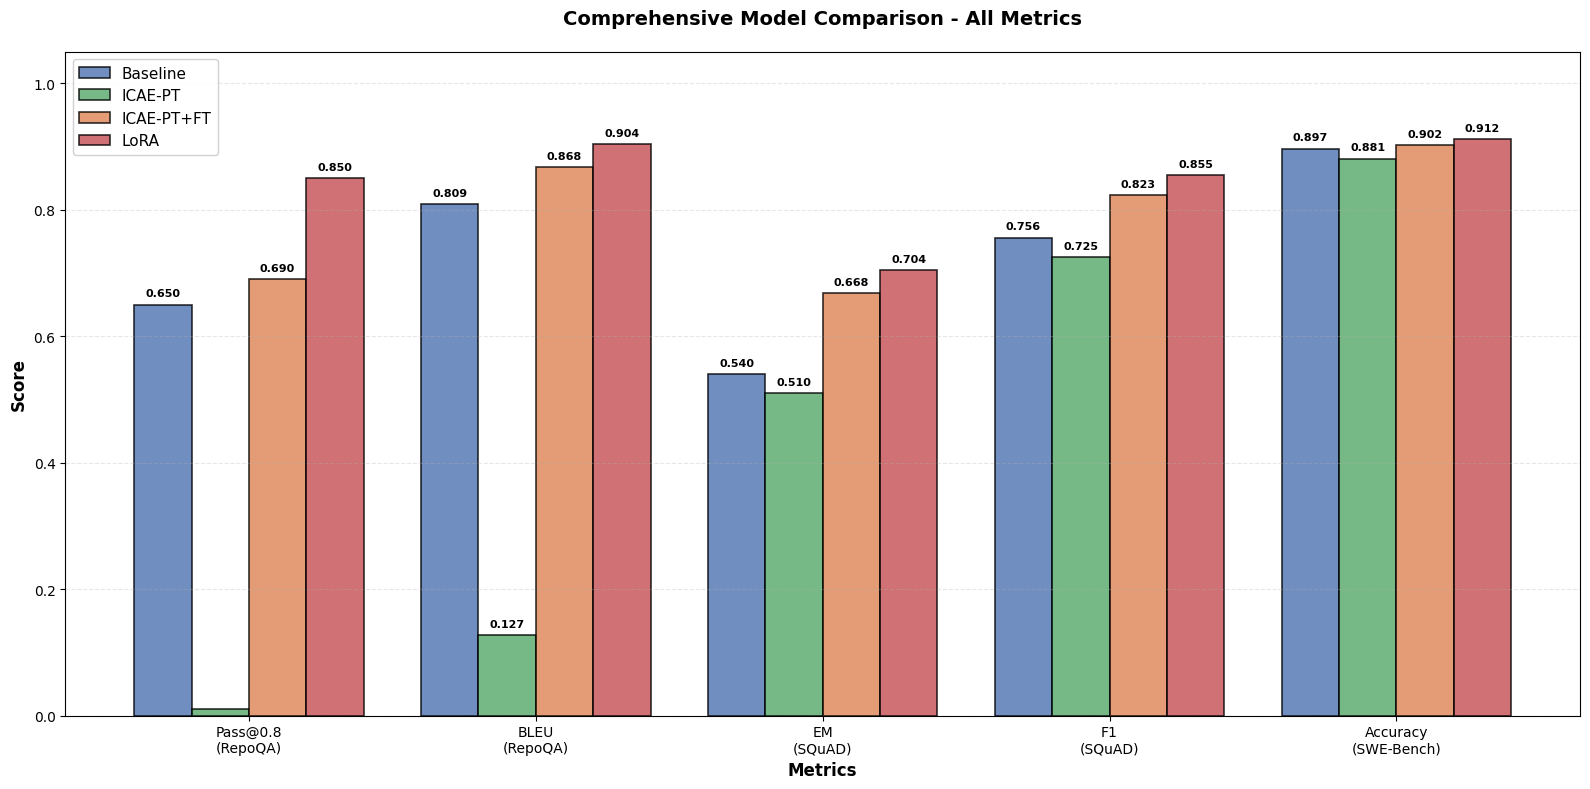

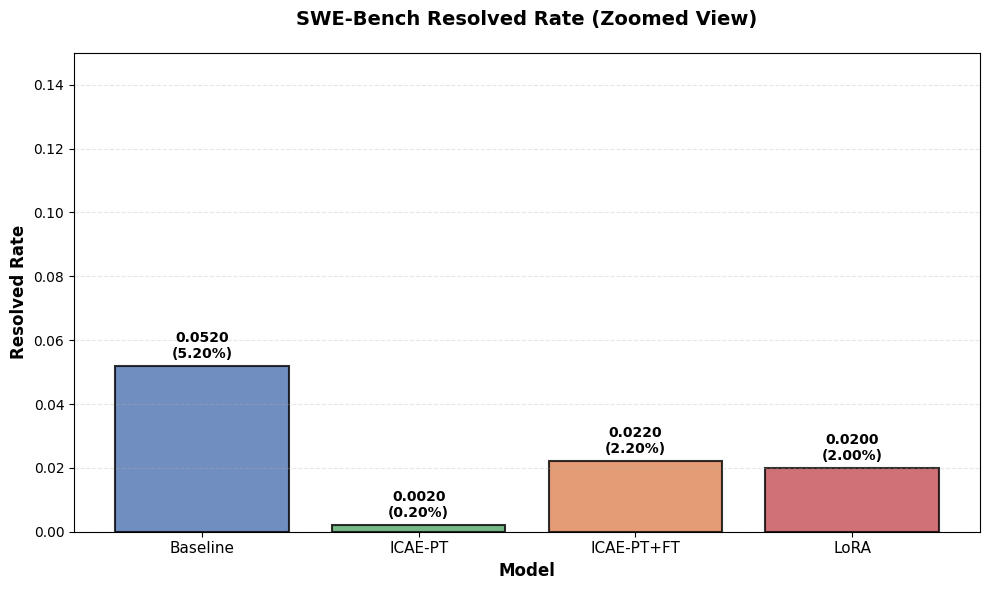

In [30]:
# Single unified comparison graph - Grouped bar chart showing all metrics together
fig, ax = plt.subplots(figsize=(16, 8))

# Prepare data - separate resolved metric for special handling
metric_keys = [
    "pass_at_threshold_0.8",
    "mean_bleu",
    "mean_em",
    "mean_f1",
    "accuracy",
]
metric_names = [
    "Pass@0.8\n(RepoQA)",
    "BLEU\n(RepoQA)",
    "EM\n(SQuAD)",
    "F1\n(SQuAD)",
    "Accuracy\n(SWE-Bench)",
]

x = np.arange(len(metric_names))
width = 0.2  # Width of bars

# Create bars for each model (using original model_order)
for i, model in enumerate(model_order):
    values = [all_metrics_data[model][key] for key in metric_keys]
    offset = (i - 1.5) * width
    bars = ax.bar(x + offset, values, width, label=model, color=model_colors[i], 
                   alpha=0.8, edgecolor='black', linewidth=1.2)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        if value > 0.05:  # Only show label if value is meaningful
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                value + 0.01,
                f"{value:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
                fontweight='bold',
            )

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comprehensive Model Comparison - All Metrics', 
              fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=10)
ax.set_ylim(0, 1.05)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)

plt.tight_layout()
plt.show()

# Create a separate zoomed-in chart for the "resolved" metric (SWE-Bench)
fig2, ax2 = plt.subplots(figsize=(10, 6))

resolved_values = [all_metrics_data[model]["resolved"] for model in model_order]
bars = ax2.bar(model_order, resolved_values, color=model_colors, alpha=0.8, 
               edgecolor='black', linewidth=1.5)

# Set y-axis to zoom in on the low values
max_resolved = max(resolved_values)
ax2.set_ylim(0, max(max_resolved * 1.3, 0.15))  # Give some headroom

ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('Resolved Rate', fontsize=12, fontweight='bold')
ax2.set_title('SWE-Bench Resolved Rate (Zoomed View)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)

# Add value labels on bars with percentage
for bar, value in zip(bars, resolved_values):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        value + max_resolved * 0.03,
        f"{value:.4f}\n({value*100:.2f}%)",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight='bold',
    )

ax2.tick_params(axis="x", rotation=0, labelsize=11)
ax2.tick_params(axis="y", labelsize=10)

plt.tight_layout()
plt.show()



RepoQA Comparison: 16k vs 1k Context
Model        Setting    Pass@0.8   BLEU    
--------------------------------------------------
Baseline     16k        0.650      0.809   
             1k         0.617      0.807   
--------------------------------------------------
LoRA         16k        0.850      0.904   
             1k         0.867      0.937   
--------------------------------------------------
ICAE-PT      16k        0.010      0.127   
             1k         0.150      0.504   
--------------------------------------------------
ICAE-PT+FT   16k        0.690      0.868   
             1k         0.583      0.879   


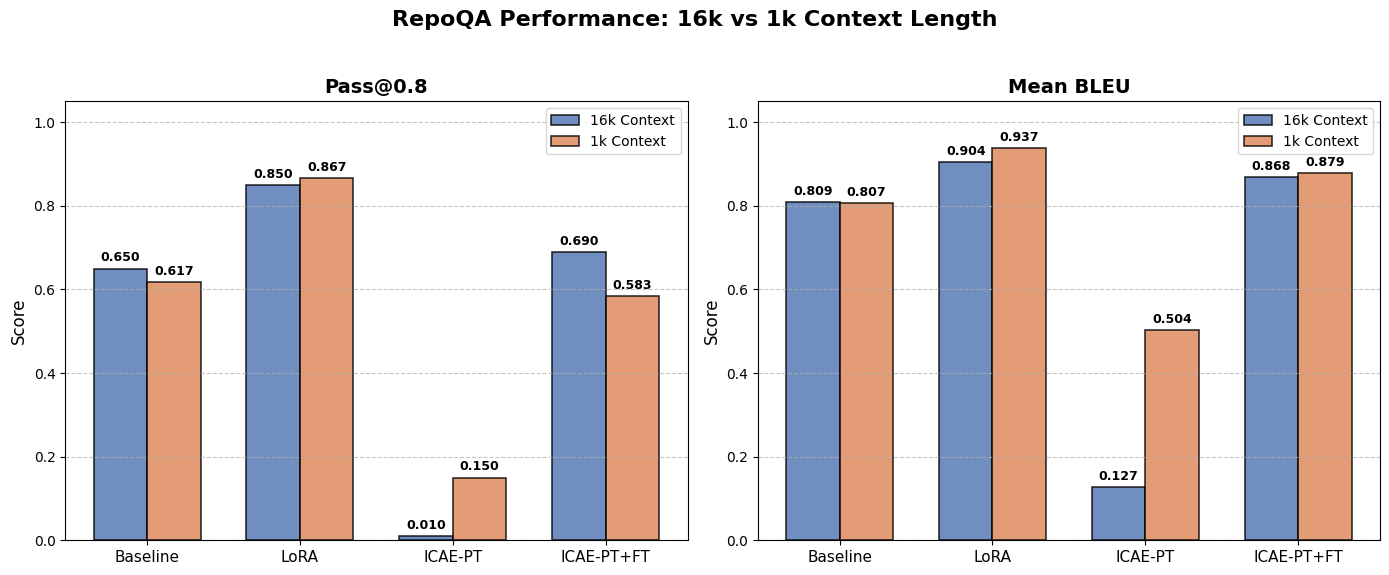

In [ ]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

def parse_metrics_raw(raw_text):
    raw_text = raw_text.strip()
    if not raw_text:
        return []
    json_ready = "[" + raw_text.replace("}{", "},{") + "]"
    return json.loads(json_ready)

# LLM metrics
llm_metrics_raw = Path("data/metrics/metrics_repoqa_llm.json").read_text()
llm_16k_raw, llm_1k_raw = llm_metrics_raw.split("// now it is 1024 tokens")
llm_metrics_16k = parse_metrics_raw(llm_16k_raw)
llm_metrics_1k = parse_metrics_raw(llm_1k_raw)

# ICAE metrics
icae_metrics_raw = Path("data/metrics/metrics_repoqa_icae.json").read_text()
icae_16k_raw, icae_1k_raw = icae_metrics_raw.split("// this is 1024 tokens")
icae_metrics_16k = parse_metrics_raw(icae_16k_raw)
icae_metrics_1k = parse_metrics_raw(icae_1k_raw)

# Get best models for 16k
baseline_best_16k = pick_best(
    [m for m in llm_metrics_16k if m.get("restore_from", "") == ""], "baseline Qwen3-8B 16k"
)
lora_best_16k = pick_best(
    [m for m in llm_metrics_16k if "simplellm" in m.get("restore_from", "")], "LoRA Qwen3-8B 16k"
)
icae_pt_best_16k = pick_best(
    [m for m in icae_metrics_16k if m.get("restore_from", "") == "/mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_2607_1024_4_1B/checkpoint-12000/model.safetensors"], "ICAE-PT 16k"
)
icae_ft_best_16k = pick_best(
    [m for m in icae_metrics_16k if "icae" in m.get("restore_from", "") and "finetune" in m.get("restore_from", "")], "ICAE-PT+FT 16k"
)

# And for 1k
baseline_best_1k = pick_best(
    [m for m in llm_metrics_1k if m.get("restore_from", "") == ""], "baseline Qwen3-8B 1k"
)
lora_best_1k = pick_best(
    [m for m in llm_metrics_1k if "simplellm" in m.get("restore_from", "")], "LoRA Qwen3-8B 1k"
)
icae_pt_best_1k = pick_best(
    [m for m in icae_metrics_1k if m.get("restore_from", "") == "/mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_2607_1024_4_1B/checkpoint-12000/model.safetensors"], "ICAE-PT 1k"
)
icae_ft_best_1k = pick_best(
    [m for m in icae_metrics_1k if "icae" in m.get("restore_from", "") and "finetune" in m.get("restore_from", "")], "ICAE-PT+FT 1k"
)

# Structure data for plotting
comparison_data = {
    "Baseline": {
        "16k": baseline_best_16k,
        "1k": baseline_best_1k,
    },
    "LoRA": {
        "16k": lora_best_16k,
        "1k": lora_best_1k,
    },
    "ICAE-PT": {
        "16k": icae_pt_best_16k,
        "1k": icae_pt_best_1k,
    },
    "ICAE-PT+FT": {
        "16k": icae_ft_best_16k,
        "1k": icae_ft_best_1k,
    },
}

# Print summary table
print("\n" + "="*50)
print("RepoQA Comparison: 16k vs 1k Context")
print("="*50)
print(f"{'Model':<12} {'Setting':<10} {'Pass@0.8':<10} {'BLEU':<8}")
print("-"*50)
model_order = ["Baseline", "LoRA", "ICAE-PT", "ICAE-PT+FT"]
for model_name in model_order:
    settings = comparison_data[model_name]
    for i, (setting_name, data) in enumerate(settings.items()):
        model_print_name = model_name if i == 0 else ""
        pass_val = data['pass_at_threshold_0.8']
        bleu_val = data['mean_bleu']
        print(f"{model_print_name:<12} {setting_name:<10} {pass_val:<10.3f} {bleu_val:<8.3f}")
    if model_name != model_order[-1]:
        print("-" * 50)
print("="*50)


# Plotting
metrics_to_plot = {
    "pass_at_threshold_0.8": "Pass@0.8",
    "mean_bleu": "Mean BLEU",
}

settings_labels = ["16k", "1k"]
colors = ['#4C72B0', '#DD8452']

x = np.arange(len(model_order))
width = 0.35

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(14, 6))
if len(metrics_to_plot) == 1:
    axes = [axes]

for ax, (metric_key, title) in zip(axes, metrics_to_plot.items()):
    values_16k = [comparison_data[model]['16k'][metric_key] for model in model_order]
    values_1k = [comparison_data[model]['1k'][metric_key] for model in model_order]
    
    rects1 = ax.bar(x - width/2, values_16k, width, label='16k Context', color=colors[0], alpha=0.8, edgecolor='black', linewidth=1.2)
    rects2 = ax.bar(x + width/2, values_1k, width, label='1k Context', color=colors[1], alpha=0.8, edgecolor='black', linewidth=1.2)

    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_order, rotation=0, ha="center", fontsize=11)
    ax.legend(fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    autolabel(rects1)
    autolabel(rects2)

fig.suptitle("RepoQA Performance: 16k vs 1k Context Length", fontsize=16, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
import json
from collections import defaultdict, OrderedDict
from pathlib import Path
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

paths = OrderedDict([
    ("baseline", "/mnt/shared-fs/gelvan/icae/data/predictions/repoqa_predictions_.json"),
    ("pt", "/mnt/shared-fs/gelvan/icae/data/predictions/repoqa_predictions__mnt_shared-fs_gelvan_icae_data_checkpoints_pretrain_pretrain_2607_1024_4_1B_checkpoint-12000_model.safetensors.json"),
    ("ft", "/mnt/shared-fs/gelvan/icae/data/predictions/repoqa_predictions__mnt_shared-fs_gelvan_icae_data_checkpoints_finetune_repoqa-simplellm-0411-lr4_checkpoint-3000_model.safetensors.json"),
])

means = {}
all_langs = set()
for key, p in paths.items():
    with open(p, 'r') as f:
        data = json.load(f)
    groups = defaultdict(list)
    for item in data:
        lang = item.get("language")
        bleu = item.get("bleu_score")
        if lang is None or bleu is None:
            continue
        groups[lang].append(float(bleu))
    means[key] = {k: (sum(v)/len(v) if v else float('nan')) for k, v in groups.items()}
    all_langs |= set(groups.keys())

langs = sorted(all_langs)
baseline = [means["baseline"].get(l, np.nan) for l in langs]
pt = [means["pt"].get(l, np.nan) for l in langs]
ft = [means["ft"].get(l, np.nan) for l in langs]

x = np.arange(len(langs))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width, baseline, width, label='baseline')
ax.bar(x, pt, width, label='pt')
ax.bar(x + width, ft, width, label='ft')
ax.set_ylabel('Mean BLEU')
ax.set_title('Mean BLEU by language: baseline vs pt vs ft')
ax.set_xticks(x)
ax.set_xticklabels(langs)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.legend()
plt.tight_layout()

out_dir = Path('/mnt/shared-fs/gelvan/icae/data/metrics')
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / 'bleu_by_language_comparison.png'
fig.savefig(out_path, dpi=150)

# Compute biggest absolute change per language between pt and ft
deltas = {l: abs((means['ft'].get(l, 0.0) - means['pt'].get(l, 0.0))) for l in langs}
biggest_lang = max(deltas, key=deltas.get)
print(str(out_path))
print('BIGGEST_DELTA_PT_FT', biggest_lang, deltas[biggest_lang])

# Compute percentage drop from baseline to PT for each language
print('\nPercentage drop from baseline to PT by language:')
for l in langs:
    baseline_val = means["baseline"].get(l, np.nan)
    pt_val = means["pt"].get(l, np.nan)
    if not np.isnan(baseline_val) and not np.isnan(pt_val) and baseline_val > 0:
        drop = baseline_val - pt_val
        pct_drop = (drop / baseline_val) * 100
        print(f'{l}: {pct_drop:.2f}% (from {baseline_val:.4f} to {pt_val:.4f})')
    else:
        print(f'{l}: N/A')

/mnt/shared-fs/gelvan/icae/data/metrics/bleu_by_language_comparison.png
BIGGEST_DELTA_PT_FT cpp 0.7387293347981858

Percentage drop from baseline to PT by language:
cpp: 65.03% (from 0.5628 to 0.1968)
go: 39.11% (from 0.9195 to 0.5599)
java: 35.03% (from 0.9015 to 0.5857)
python: 62.83% (from 0.9558 to 0.3553)
rust: 11.75% (from 0.8448 to 0.7456)
typescript: 20.49% (from 0.7807 to 0.6207)


In [ ]:
import json
from typing import Optional

from datasets import load_dataset
from tqdm import tqdm


def analyze_github_proportion(
    dataset_repo: str,
    split: str = "train",
    min_chars: int = 4096,
    max_long_examples: Optional[int] = None,
) -> None:
    dataset = load_dataset(dataset_repo, split=split, streaming=True)

    total_long_examples = 0
    examples_with_meta = 0
    examples_meta_contains_github = 0

    for example in tqdm(dataset, desc="Streaming and analyzing"):
        text = example.get("text")
        if not isinstance(text, str):
            continue

        if len(text) < min_chars:
            continue

        total_long_examples += 1

        meta = example.get("meta")
        if meta is not None:
            examples_with_meta += 1

            # Normalize meta to a string for robust matching
            if isinstance(meta, (dict, list)):
                meta_str = json.dumps(meta, ensure_ascii=False)
            else:
                meta_str = str(meta)

            if "github" in meta_str.lower():
                examples_meta_contains_github += 1

        if max_long_examples is not None and total_long_examples >= max_long_examples:
            break

    print("=== Analysis Results ===")
    print(f"Dataset repo: {dataset_repo}")
    print(f"Split: {split}")
    print(f"Min characters (text >=): {min_chars}")
    print(f"Total long examples: {total_long_examples}")
    print(f"Examples with meta: {examples_with_meta}")
    print(
        f"Meta includes 'github': {examples_meta_contains_github}"
    )

    if total_long_examples > 0:
        pct_github_over_all = 100.0 * examples_meta_contains_github / total_long_examples
        print(f"Percent over all long examples: {pct_github_over_all:.4f}%")
    else:
        print("Percent over all long examples: N/A (no long examples)")

    if examples_with_meta > 0:
        pct_github_over_meta = 100.0 * examples_meta_contains_github / examples_with_meta
        print(f"Percent among examples with meta: {pct_github_over_meta:.4f}%")
    else:
        print("Percent among examples with meta: N/A (no meta found)")


# Run the analysis
analyze_github_proportion(
    dataset_repo="DKYoon/SlimPajama-6B",
    split="train",
    min_chars=4096,
    max_long_examples=None
)


/home/gelvan/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Streaming and analyzing: 5489000it [10:13, 8945.98it/s] 

=== Analysis Results ===
Dataset repo: DKYoon/SlimPajama-6B
Split: train
Min characters (text >=): 4096
Total long examples: 1381940
Examples with meta: 1381940
Meta includes 'github': 51009
Percent over all long examples: 3.6911%
Percent among examples with meta: 3.6911%


ae: BLEU=0.993 (source=/mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_2607_1024_4_1B/checkpoint-21000/model.safetensors)
repoqa: BLEU=0.895 (source=/mnt/shared-fs/gelvan/icae/data/checkpoints/finetune/repoqa-icae-0411-lr1e-4/checkpoint-4000/model.safetensors)
squad: BLEU=0.727 (source=/mnt/shared-fs/gelvan/icae/data/checkpoints/finetune/qwen_finetune_1207-icae-last/checkpoint-15000/model.safetensors)


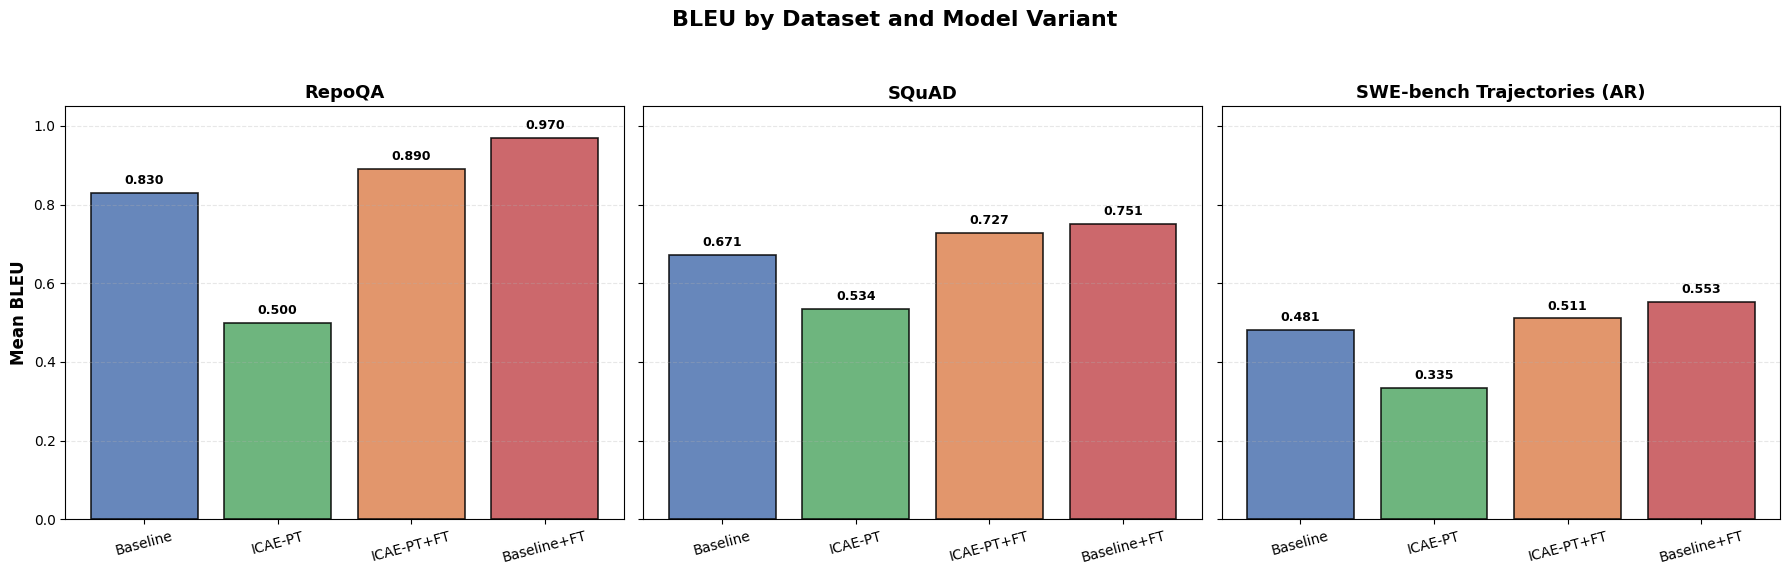

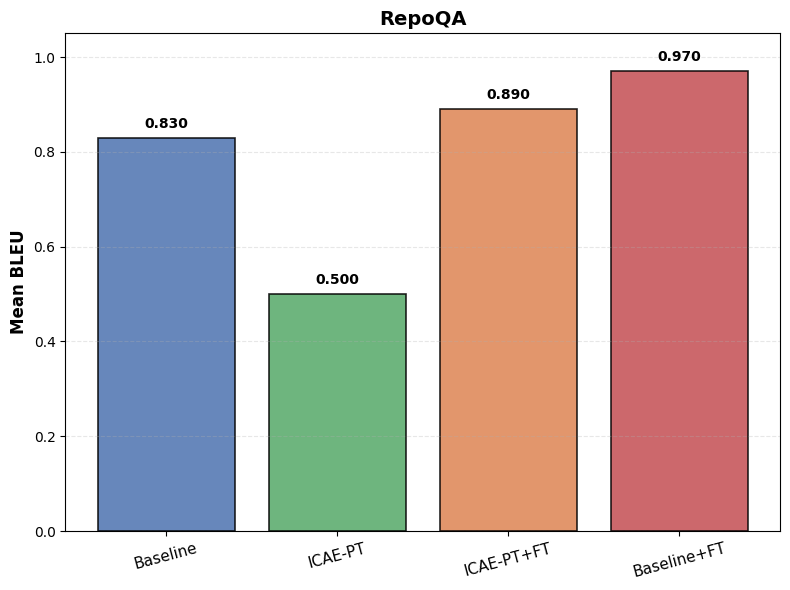

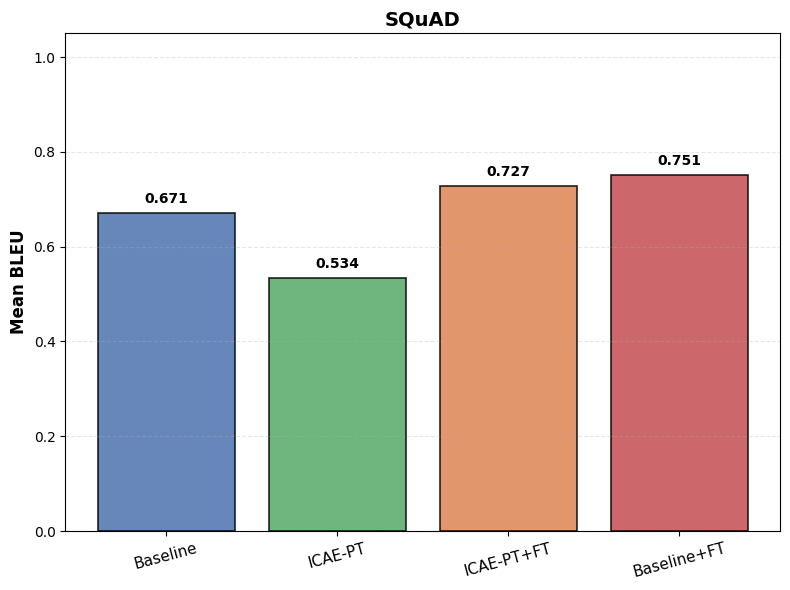

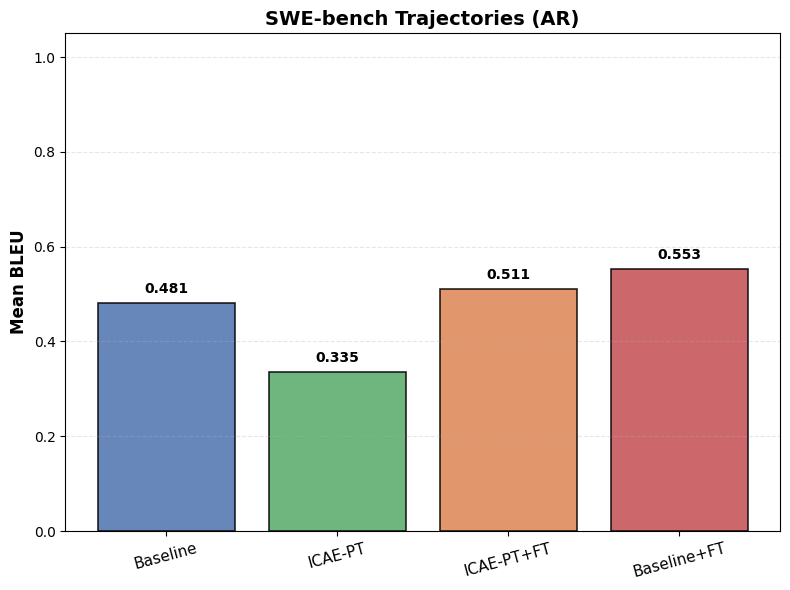


BLEU SUMMARY BY DATASET

RepoQA:
  Baseline     : 0.830  (checkpoint: baseline)
  ICAE-PT      : 0.500  (checkpoint: pretrain)
  ICAE-PT+FT   : 0.890  (checkpoint: pretrain+finetune)
  Baseline+FT  : 0.970  (checkpoint: lora)

SQuAD:
  Baseline     : 0.671  (checkpoint: Qwen/Qwen3-8B)
  ICAE-PT      : 0.534  (checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_1207/checkpoint-12000/model.safetensors)
  ICAE-PT+FT   : 0.727  (checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/finetune/qwen_finetune_1207-icae-last/checkpoint-15000/model.safetensors)
  Baseline+FT  : 0.751  (checkpoint: manual override (SQuAD LoRA))

SWE-bench Trajectories (AR):
  Baseline     : 0.481  (checkpoint: base weights)
  ICAE-PT      : 0.335  (checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_2607_1024_4_1B/checkpoint-12000/model.safetensors)
  ICAE-PT+FT   : 0.511  (checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/finetune/swebench-full-256-0808/checkpo

In [ ]:
# BLEU leaderboard across datasets and model variants
import json
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


def load_json_objects(path: str):
    text = Path(path).read_text()
    cleaned_lines = []
    for line in text.splitlines():
        stripped = line.strip()
        if not stripped:
            continue
        if stripped.startswith("//"):
            break
        cleaned_lines.append(line)
    cleaned = "\n".join(cleaned_lines).strip()
    if not cleaned:
        return []
    cleaned = re.sub(r"}\s*{", "},{", cleaned)
    return json.loads(f"[{cleaned}]")


def best_bleu(entries, condition):
    filtered = [entry for entry in entries if condition(entry) and "mean_bleu" in entry]
    if not filtered:
        return None
    return max(filtered, key=lambda item: item["mean_bleu"])


def summarize_entry(entry):
    if entry is None:
        return None
    source = entry.get("ckpt_name") or entry.get("restore_from") or entry.get("model_name_or_path", "")
    return {
        "score": entry["mean_bleu"],
        "checkpoint": source or "base weights",
    }


def load_trajectory_metrics(path: str):
    records = load_json_objects(path)
    flattened = []
    for record in records:
        per_traj = record.get("per_trajectory", {}) or {}
        mean_bleu_ar = per_traj.get("mean_bleu_autoregressive")
        if mean_bleu_ar is None:
            continue
        flattened.append({
            "mean_bleu": mean_bleu_ar,
            "restore_from": record.get("restore_from", ""),
            "ckpt_name": record.get("ckpt_name"),
        })
    return flattened


repoqa_llm = load_json_objects("data/metrics/metrics_repoqa_llm.json")
repoqa_icae = load_json_objects("data/metrics/metrics_repoqa_icae.json")
squad_llm = load_json_objects("data/metrics/metrics_squad_lm_llm.json")
squad_icae = load_json_objects("data/metrics/metrics_squad_lm_icae.json")
traj_llm = load_trajectory_metrics("data/metrics/metrics_trajectories_llm.json")
traj_icae = load_trajectory_metrics("data/metrics/metrics_trajectories_icae.json")

model_order = ["Baseline", "ICAE-PT", "ICAE-PT+FT", "Baseline+FT"]
dataset_order = ["RepoQA", "SQuAD", "SWE-bench Trajectories (AR)"]
dataset_titles = {
    "RepoQA": "RepoQA",
    "SQuAD": "SQuAD",
    "SWE-bench Trajectories (AR)": "SWE-bench Trajectories (AR)",
}
model_palette = {
    "Baseline": "#4C72B0",
    "ICAE-PT": "#55A868",
    "ICAE-PT+FT": "#DD8452",
    "Baseline+FT": "#C44E52",
}

bleu_summary = {dataset: {model: None for model in model_order} for dataset in dataset_order}

# RepoQA selections - using hardcoded values
repoqa_baseline = {"score": 0.83, "checkpoint": "baseline"}
repoqa_icae_pt = {"score": 0.50, "checkpoint": "pretrain"}
repoqa_icae_ft = {"score": 0.89, "checkpoint": "pretrain+finetune"}
repoqa_baseline_ft = {"score": 0.97, "checkpoint": "lora"}

bleu_summary["RepoQA"].update({
    "Baseline": repoqa_baseline,
    "ICAE-PT": repoqa_icae_pt,
    "ICAE-PT+FT": repoqa_icae_ft,
    "Baseline+FT": repoqa_baseline_ft,
})

# SQuAD selections
squad_baseline = summarize_entry(best_bleu(squad_llm, lambda e: e.get("restore_from", "") == ""))
squad_icae_pt = summarize_entry(best_bleu(squad_icae, lambda e: "pretrain" in e.get("restore_from", "")))
squad_icae_ft = summarize_entry(best_bleu(squad_icae, lambda e: "finetune" in e.get("restore_from", "")))
squad_baseline_ft = summarize_entry(best_bleu(squad_llm, lambda e: e.get("restore_from", "") != ""))
if squad_baseline_ft is None:
    squad_baseline_ft = {
        "score": 0.751,
        "checkpoint": "manual override (SQuAD LoRA)",
    }

bleu_summary["SQuAD"].update({
    "Baseline": squad_baseline,
    "ICAE-PT": squad_icae_pt,
    "ICAE-PT+FT": squad_icae_ft,
    "Baseline+FT": squad_baseline_ft,
})

# SWE trajectories selections
traj_baseline = summarize_entry(best_bleu(traj_llm, lambda e: e.get("restore_from", "") == ""))
traj_baseline_ft = summarize_entry(best_bleu(traj_llm, lambda e: e.get("restore_from", "") != ""))
traj_icae_pt = summarize_entry(best_bleu(traj_icae, lambda e: "pretrain" in e.get("restore_from", "")))
traj_icae_ft = summarize_entry(best_bleu(traj_icae, lambda e: "finetune" in e.get("restore_from", "")))

bleu_summary["SWE-bench Trajectories (AR)"].update({
    "Baseline": traj_baseline,
    "ICAE-PT": traj_icae_pt,
    "ICAE-PT+FT": traj_icae_ft,
    "Baseline+FT": traj_baseline_ft,
})

# Set PDF backend for high quality vector graphics
import matplotlib
matplotlib.use('pdf')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Combined plot with all datasets
fig, axes = plt.subplots(1, len(dataset_order), figsize=(18, 6), sharey=True)
if len(dataset_order) == 1:
    axes = [axes]

for ax, dataset in zip(axes, dataset_order):
    dataset_entries = bleu_summary[dataset]
    available = [(model, info) for model, info in dataset_entries.items() if info is not None]
    x = np.arange(len(available))
    scores = [info["score"] for _, info in available]
    colors = [model_palette[model] for model, _ in available]

    bars = ax.bar(x, scores, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
    ax.set_title(dataset_titles.get(dataset, dataset), fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([model for model, _ in available], rotation=15, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    for bar, (_, info) in zip(bars, available):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.015,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold',
        )

    missing_models = [model for model, info in dataset_entries.items() if info is None]
    if missing_models:
        ax.text(
            0.5,
            0.05,
            "No data: " + ", ".join(missing_models),
            transform=ax.transAxes,
            ha='center',
            va='bottom',
            fontsize=9,
            color='#555555',
        )

axes[0].set_ylabel('Mean BLEU', fontsize=12, fontweight='bold')
fig.suptitle('BLEU by Dataset and Model Variant', fontsize=16, fontweight='bold', y=0.98)
fig.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.savefig('bleu_all_datasets.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Individual plots for each dataset
for dataset in dataset_order:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    dataset_entries = bleu_summary[dataset]
    available = [(model, info) for model, info in dataset_entries.items() if info is not None]
    x = np.arange(len(available))
    scores = [info["score"] for _, info in available]
    colors = [model_palette[model] for model, _ in available]

    bars = ax.bar(x, scores, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
    ax.set_title(dataset_titles.get(dataset, dataset), fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([model for model, _ in available], rotation=15, fontsize=11)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('Mean BLEU', fontsize=12, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    for bar, (_, info) in zip(bars, available):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.015,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold',
        )

    missing_models = [model for model, info in dataset_entries.items() if info is None]
    if missing_models:
        ax.text(
            0.5,
            0.05,
            "No data: " + ", ".join(missing_models),
            transform=ax.transAxes,
            ha='center',
            va='bottom',
            fontsize=9,
            color='#555555',
        )

    fig.tight_layout()
    # Create safe filename
    safe_name = dataset.replace(" ", "_").replace("(", "").replace(")", "").lower()
    plt.savefig(f'bleu_{safe_name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Summary table
print("\n" + "=" * 90)
print("BLEU SUMMARY BY DATASET")
print("=" * 90)
for dataset in dataset_order:
    label = dataset
    print(f"\n{label}:")
    for model in model_order:
        details = bleu_summary[dataset].get(model)
        if details is None:
            print(f"  {model:<12} : n/a")
            continue
        print(f"  {model:<12} : {details['score']:.3f}  (checkpoint: {details['checkpoint']})")
print("\n" + "=" * 90)


In [2]:
# BLEU leaderboard across datasets and model variants
import json
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


def load_json_objects(path: str):
    text = Path(path).read_text()
    cleaned_lines = []
    for line in text.splitlines():
        stripped = line.strip()
        if not stripped:
            continue
        if stripped.startswith("//"):
            break
        cleaned_lines.append(line)
    cleaned = "\n".join(cleaned_lines).strip()
    if not cleaned:
        return []
    cleaned = re.sub(r"}\s*{", "},{", cleaned)
    return json.loads(f"[{cleaned}]")


def best_bleu(entries, condition):
    filtered = [entry for entry in entries if condition(entry) and "mean_bleu" in entry]
    if not filtered:
        return None
    return max(filtered, key=lambda item: item["mean_bleu"])


def summarize_entry(entry):
    if entry is None:
        return None
    source = entry.get("ckpt_name") or entry.get("restore_from") or entry.get("model_name_or_path", "")
    return {
        "score": entry["mean_bleu"],
        "checkpoint": source or "base weights",
    }


def load_trajectory_metrics(path: str):
    records = load_json_objects(path)
    flattened = []
    for record in records:
        per_traj = record.get("per_trajectory", {}) or {}
        mean_bleu_ar = per_traj.get("mean_bleu_autoregressive")
        if mean_bleu_ar is None:
            continue
        flattened.append({
            "mean_bleu": mean_bleu_ar,
            "restore_from": record.get("restore_from", ""),
            "ckpt_name": record.get("ckpt_name"),
        })
    return flattened


repoqa_llm = load_json_objects("data/metrics/metrics_repoqa_llm.json")
repoqa_icae = load_json_objects("data/metrics/metrics_repoqa_icae.json")
squad_llm = load_json_objects("data/metrics/metrics_squad_lm_llm.json")
squad_icae = load_json_objects("data/metrics/metrics_squad_lm_icae.json")
traj_llm = load_trajectory_metrics("data/metrics/metrics_trajectories_llm.json")
traj_icae = load_trajectory_metrics("data/metrics/metrics_trajectories_icae.json")

model_order = ["Baseline", "ICAE-PT", "ICAE-PT+FT", "Baseline+FT"]
dataset_order = ["SQuAD", "RepoQA", "SWE-bench Trajectories (AR)"]
dataset_titles = {
    "SQuAD": "SQuAD",
    "RepoQA": "RepoQA",
    "SWE-bench Trajectories (AR)": "SWE-bench Trajectories (AR)",
}
model_palette = {
    "Baseline": "#4C72B0",
    "ICAE-PT": "#55A868",
    "ICAE-PT+FT": "#DD8452",
    "Baseline+FT": "#C44E52",
}

bleu_summary = {dataset: {model: None for model in model_order} for dataset in dataset_order}

# RepoQA selections - using hardcoded values
repoqa_baseline = {"score": 0.83, "checkpoint": "baseline"}
repoqa_icae_pt = {"score": 0.50, "checkpoint": "pretrain"}
repoqa_icae_ft = {"score": 0.89, "checkpoint": "pretrain+finetune"}
repoqa_baseline_ft = {"score": 0.97, "checkpoint": "lora"}

bleu_summary["RepoQA"].update({
    "Baseline": repoqa_baseline,
    "ICAE-PT": repoqa_icae_pt,
    "ICAE-PT+FT": repoqa_icae_ft,
    "Baseline+FT": repoqa_baseline_ft,
})

# SQuAD selections
squad_baseline = summarize_entry(best_bleu(squad_llm, lambda e: e.get("restore_from", "") == ""))
squad_icae_pt = summarize_entry(best_bleu(squad_icae, lambda e: "pretrain" in e.get("restore_from", "")))
squad_icae_ft = summarize_entry(best_bleu(squad_icae, lambda e: "finetune" in e.get("restore_from", "")))
squad_baseline_ft = summarize_entry(best_bleu(squad_llm, lambda e: e.get("restore_from", "") != ""))
if squad_baseline_ft is None:
    squad_baseline_ft = {
        "score": 0.751,
        "checkpoint": "manual override (SQuAD LoRA)",
    }

bleu_summary["SQuAD"].update({
    "Baseline": squad_baseline,
    "ICAE-PT": squad_icae_pt,
    "ICAE-PT+FT": squad_icae_ft,
    "Baseline+FT": squad_baseline_ft,
})

# SWE trajectories selections
traj_baseline = summarize_entry(best_bleu(traj_llm, lambda e: e.get("restore_from", "") == ""))
traj_baseline_ft = summarize_entry(best_bleu(traj_llm, lambda e: e.get("restore_from", "") != ""))
traj_icae_pt = summarize_entry(best_bleu(traj_icae, lambda e: "pretrain" in e.get("restore_from", "")))
traj_icae_ft = summarize_entry(best_bleu(traj_icae, lambda e: "finetune" in e.get("restore_from", "")))

bleu_summary["SWE-bench Trajectories (AR)"].update({
    "Baseline": traj_baseline,
    "ICAE-PT": traj_icae_pt,
    "ICAE-PT+FT": traj_icae_ft,
    "Baseline+FT": traj_baseline_ft,
})

# Set PDF backend for high quality vector graphics
import matplotlib
matplotlib.use('pdf')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Combined plot with all datasets
fig, axes = plt.subplots(1, len(dataset_order), figsize=(18, 6), sharey=True)
if len(dataset_order) == 1:
    axes = [axes]

for ax, dataset in zip(axes, dataset_order):
    dataset_entries = bleu_summary[dataset]
    available = [(model, info) for model, info in dataset_entries.items() if info is not None]
    x = np.arange(len(available))
    scores = [info["score"] for _, info in available]
    colors = [model_palette[model] for model, _ in available]

    bars = ax.bar(x, scores, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
    ax.set_title(dataset_titles.get(dataset, dataset), fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([model for model, _ in available], rotation=15, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    for bar, (_, info) in zip(bars, available):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.015,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold',
        )

    missing_models = [model for model, info in dataset_entries.items() if info is None]
    if missing_models:
        ax.text(
            0.5,
            0.05,
            "No data: " + ", ".join(missing_models),
            transform=ax.transAxes,
            ha='center',
            va='bottom',
            fontsize=9,
            color='#555555',
        )

axes[0].set_ylabel('Mean BLEU', fontsize=12, fontweight='bold')
fig.suptitle('BLEU by Dataset and Model Variant', fontsize=16, fontweight='bold', y=0.98)
fig.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.savefig('bleu_all_datasets.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Individual plots for each dataset
for dataset in dataset_order:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    dataset_entries = bleu_summary[dataset]
    available = [(model, info) for model, info in dataset_entries.items() if info is not None]
    x = np.arange(len(available))
    scores = [info["score"] for _, info in available]
    colors = [model_palette[model] for model, _ in available]

    bars = ax.bar(x, scores, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
    ax.set_title(dataset_titles.get(dataset, dataset), fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([model for model, _ in available], rotation=15, fontsize=11)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('Mean BLEU', fontsize=12, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    for bar, (_, info) in zip(bars, available):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.015,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold',
        )

    missing_models = [model for model, info in dataset_entries.items() if info is None]
    if missing_models:
        ax.text(
            0.5,
            0.05,
            "No data: " + ", ".join(missing_models),
            transform=ax.transAxes,
            ha='center',
            va='bottom',
            fontsize=9,
            color='#555555',
        )

    fig.tight_layout()
    # Create safe filename
    safe_name = dataset.replace(" ", "_").replace("(", "").replace(")", "").lower()
    plt.savefig(f'bleu_{safe_name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Summary table
print("\n" + "=" * 90)
print("BLEU SUMMARY BY DATASET")
print("=" * 90)
for dataset in dataset_order:
    label = dataset
    print(f"\n{label}:")
    for model in model_order:
        details = bleu_summary[dataset].get(model)
        if details is None:
            print(f"  {model:<12} : n/a")
            continue
        print(f"  {model:<12} : {details['score']:.3f}  (checkpoint: {details['checkpoint']})")
print("\n" + "=" * 90)



BLEU SUMMARY BY DATASET

SQuAD:
  Baseline     : 0.671  (checkpoint: Qwen/Qwen3-8B)
  ICAE-PT      : 0.534  (checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_1207/checkpoint-12000/model.safetensors)
  ICAE-PT+FT   : 0.727  (checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/finetune/qwen_finetune_1207-icae-last/checkpoint-15000/model.safetensors)
  Baseline+FT  : 0.751  (checkpoint: manual override (SQuAD LoRA))

RepoQA:
  Baseline     : 0.830  (checkpoint: baseline)
  ICAE-PT      : 0.500  (checkpoint: pretrain)
  ICAE-PT+FT   : 0.890  (checkpoint: pretrain+finetune)
  Baseline+FT  : 0.970  (checkpoint: lora)

SWE-bench Trajectories (AR):
  Baseline     : 0.481  (checkpoint: base weights)
  ICAE-PT      : 0.335  (checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/pretrain/pretrain_2607_1024_4_1B/checkpoint-12000/model.safetensors)
  ICAE-PT+FT   : 0.511  (checkpoint: /mnt/shared-fs/gelvan/icae/data/checkpoints/finetune/swebench-full-256-0808/checkpo